## Project No. 10: Simple Feed Forward Neural Network
- Objective: Understand the basic building blocks of neural networks, implement a simple feedforward neural network, and train it on a small dataset.
- Task:
    - Implement a feedforward neural network from scratch using Python and NumPy.
    - Train the network on the MNIST dataset to classify handwritten digits. (https://www.kaggle.com/datasets/hojjatk/mnist-dataset)
    - Evaluate the network's performance using accuracy and confusion matrix.
- Deliverables:
    - Source code with comments.
    - A short report (2-3 pages) explaining the architecture, training process, and results.
    - Plots of training and validation accuracy/loss over epochs.
- Try simple one first, then move to complex one

---

## 1. MNIST Dataset
1. **train-images-idx3-ubyte**
- Purpose: Contains the training images.
- Description:
    - This file includes the pixel values for all training images in the dataset.
    - Each image is represented as a 28x28 grid of pixel values, stored in row-major order.
    - Each pixel is a single byte (uint8), representing a grayscale intensity (0 for black and 255 for white).

2. **train-labels-idx1-ubyte**
- Purpose: Contains the labels (ground truth) for the training images.
- Description:
    - This file provides the digit label (0-9) corresponding to each training image in train-images-idx3-ubyte.
    - Each label is stored as a single byte (uint8).

3. **t10k-images-idx3-ubyte**
- Purpose: Contains the test images.
- Description:
    - This file includes the pixel values for the test images used for evaluating model performance.
    - The format is the same as train-images-idx3-ubyte (28x28 pixel grids).

4. **t10k-labels-idx1-ubyte**
- Purpose: Contains the labels (ground truth) for the test images.
- Description:
    - This file provides the digit label (0-9) for each test image in t10k-images-idx3-ubyte.
    - The format is the same as train-labels-idx1-ubyte.

In [3]:
import numpy as np
import os
import struct
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
def load_mnist_images(filename):
    """Load MNIST image file """
    with open(filename, 'rb') as f:
        # Read the magic number and header
        magic = int.from_bytes(f.read(4), byteorder='big')
        num_images = int.from_bytes(f.read(4), byteorder='big')
        num_rows = int.from_bytes(f.read(4), byteorder='big')
        num_cols = int.from_bytes(f.read(4), byteorder='big')

        # Read the image data
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num_images, num_rows * num_cols)  # Flatten images
        images = images.astype('float32') / 255.0  # Normalize to [0, 1]

    return images


def load_mnist_labels(filename):
    """Load MNIST label file in IDX1 format."""
    with open(filename, 'rb') as f:
        # Read the magic number and header
        magic = int.from_bytes(f.read(4), byteorder='big')
        num_labels = int.from_bytes(f.read(4), byteorder='big')

        # Read the label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        
        # Convert to one-hot encoding
        one_hot = np.zeros((labels.size, 10))
        one_hot[np.arange(labels.size), labels] = 1

    return one_hot


def split_data(images, labels, train_ratio=0.8, val_ratio=0.2):
    """Split images and labels into training and validation sets."""
    assert train_ratio + val_ratio == 1.0, "Ratios must sum to 1 for training and validation."
    num_images = images.shape[0]

    # Determine split sizes
    train_size = int(train_ratio * num_images)

    # Shuffle indices
    indices = np.arange(num_images)
    np.random.shuffle(indices)

    # Split the data
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    train_images = images[train_indices]
    train_labels = labels[train_indices]
    val_images = images[val_indices]
    val_labels = labels[val_indices]

    return train_images, train_labels, val_images, val_labels

In [ ]:
baseDir = '/home2/s439831/ML_group_project/data'

X_train = load_mnist_images(os.path.join(baseDir, 'train-images-idx3-ubyte'))
y_train = load_mnist_labels(os.path.join(baseDir, 'train-labels-idx1-ubyte'))
X_test = load_mnist_images(os.path.join(baseDir, 't10k-images-idx3-ubyte'))
y_test = load_mnist_labels(os.path.join(baseDir, 't10k-labels-idx1-ubyte'))

# Split training data into training and validation sets
np.random.seed(42)
indices = np.random.permutation(len(X_train))
split = int(0.8 * len(X_train))
train_idx, val_idx = indices[:split], indices[split:]

X_val = X_train[val_idx]
y_val = y_train[val_idx]
X_train = X_train[train_idx]
y_train = y_train[train_idx]

print("Dataset shapes:")
print(f"Training: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test: {X_test.shape}")

# Network parameters
input_size = 784  # 28x28 pixels
hidden_layers = [512, 256, 128]  # Three hidden layers
output_size = 10  # 10 digits
learning_rate = 0.1
epochs = 50

Dataset shapes:
Training: (48000, 784)
Validation: (12000, 784)
Test: (10000, 784)


## 2. Simple FFNN

In [7]:
# Activation Functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Loss Function
def cross_entropy_loss(y_true, y_pred, epsilon=1e-8):
    return -np.mean(np.sum(y_true * np.log(y_pred + epsilon), axis=1))

# Forward Propagation
def forward_propagation(X, weights, biases):
    activations = [X]
    z_values = []
    for w, b in zip(weights, biases):
        z = np.dot(activations[-1], w) + b
        z_values.append(z)
        if w is not weights[-1]:  # For hidden layers
            activations.append(sigmoid(z))
        else:  # For output layer
            activations.append(softmax(z))
    return activations, z_values

# Backward Propagation
def backward_propagation(y_true, activations, z_values, weights):
    gradients_w = []
    gradients_b = []
    m = y_true.shape[0]
    dz = activations[-1] - y_true  # Output layer delta

    for i in reversed(range(len(weights))):
        dw = np.dot(activations[i].T, dz) / m
        db = np.sum(dz, axis=0, keepdims=True) / m
        gradients_w.insert(0, dw)
        gradients_b.insert(0, db)

        if i != 0:  # Skip for input layer
            dz = np.dot(dz, weights[i].T) * sigmoid_derivative(activations[i])

    return gradients_w, gradients_b

# Initialize Weights and Biases
def initialize_network(input_size, hidden_layers, output_size):
    layers = [input_size] + hidden_layers + [output_size]
    weights = [np.random.randn(layers[i], layers[i+1]) * 0.01 for i in range(len(layers)-1)]
    biases = [np.zeros((1, layer)) for layer in layers[1:]]
    return weights, biases

# Training Function
def train_network(
    X_train, 
    y_train, 
    X_val, 
    y_val, 
    input_size, 
    hidden_layers, 
    output_size, 
    epochs, 
    learning_rate
    ):
    weights, biases = initialize_network(input_size, hidden_layers, output_size)
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Forward Propagation
        activations, z_values = forward_propagation(X_train, weights, biases)

        # Compute Loss
        train_loss = cross_entropy_loss(y_train, activations[-1])
        train_losses.append(train_loss)

        # Backward Propagation
        gradients_w, gradients_b = backward_propagation(y_train, activations, z_values, weights)

        # Update Weights and Biases
        for i in range(len(weights)):
            weights[i] -= learning_rate * gradients_w[i]
            biases[i] -= learning_rate * gradients_b[i]

        # Validation Loss
        val_activations, _ = forward_propagation(X_val, weights, biases)
        val_loss = cross_entropy_loss(y_val, val_activations[-1])
        val_losses.append(val_loss)

        # Print progress
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    return weights, biases, train_losses, val_losses

def compute_accuracy(y_true, y_pred):
    """
    Compute accuracy without sklearn
    
    Args:
        y_true: One-hot encoded true labels (n_samples, n_classes)
        y_pred: One-hot encoded predicted labels (n_samples, n_classes)
    """
    # Convert from one-hot to class indices
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    # Calculate accuracy
    correct_predictions = np.sum(y_true_labels == y_pred_labels)
    total_samples = len(y_true_labels)
    
    return correct_predictions / total_samples

def compute_confusion_matrix(y_true, y_pred, num_classes=10):
    """
    Compute confusion matrix without sklearn
    
    Args:
        y_true: One-hot encoded true labels (n_samples, n_classes)
        y_pred: One-hot encoded predicted labels (n_samples, n_classes)
        num_classes: Number of classes (default: 10 for MNIST)
    """
    # Convert from one-hot to class indices
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    # Initialize confusion matrix
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    # Fill confusion matrix
    for true_label, pred_label in zip(y_true_labels, y_pred_labels):
        conf_matrix[true_label][pred_label] += 1
        
    return conf_matrix

# Update evaluate_model function to use these new functions
def evaluate_model(X_test, y_test, weights, biases):
    """
    Evaluate model performance using custom metrics
    """
    # Get predictions
    activations, _ = forward_propagation(X_test, weights, biases)
    predictions = activations[-1]  # Already in one-hot format
    
    # Compute metrics
    accuracy = compute_accuracy(y_test, predictions)
    conf_matrix = compute_confusion_matrix(y_test, predictions)
    
    return accuracy, conf_matrix

# Additional metrics you might find useful
def compute_per_class_metrics(conf_matrix):
    """
    Compute precision, recall, and F1 score for each class
    """
    num_classes = conf_matrix.shape[0]
    metrics = {
        'precision': np.zeros(num_classes),
        'recall': np.zeros(num_classes),
        'f1_score': np.zeros(num_classes)
    }
    
    for i in range(num_classes):
        # True Positives: diagonal elements
        tp = conf_matrix[i, i]
        # False Positives: sum of column i (excluding tp)
        fp = np.sum(conf_matrix[:, i]) - tp
        # False Negatives: sum of row i (excluding tp)
        fn = np.sum(conf_matrix[i, :]) - tp
        
        # Compute metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics['precision'][i] = precision
        metrics['recall'][i] = recall
        metrics['f1_score'][i] = f1
    
    return metrics

In [33]:
# Network parameters
input_size = 784  # 28x28 pixels
hidden_layers = [512, 256, 128]  # Three hidden layers
output_size = 10  # 10 digits
learning_rate = 0.1
epochs = 50

# Initialize and train the network
print("\nTraining network...")
weights, biases, train_losses, val_losses = train_network(
    X_train, y_train, X_val, y_val,
    input_size, hidden_layers, output_size,
    epochs, learning_rate
)


Training network...
Epoch 1/50 - Train Loss: 2.3035 - Val Loss: 2.3028
Epoch 11/50 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 21/50 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 31/50 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 41/50 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 50/50 - Train Loss: 2.3026 - Val Loss: 2.3026


In [34]:
# Evaluate model
accuracy, conf_matrix = evaluate_model(X_test, y_test, weights, biases)
print(f"\nTest Accuracy: {accuracy:.4f}")


Test Accuracy: 0.1000


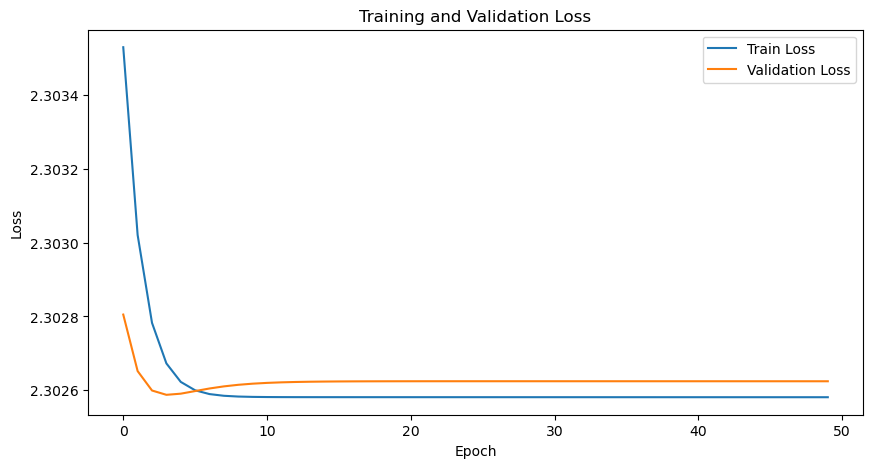

In [37]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Per-class metrics:

Class 0:
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class 1:
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class 2:
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class 3:
Precision: 0.1000
Recall: 1.0000
F1 Score: 0.1818

Class 4:
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class 5:
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class 6:
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class 7:
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class 8:
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class 9:
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


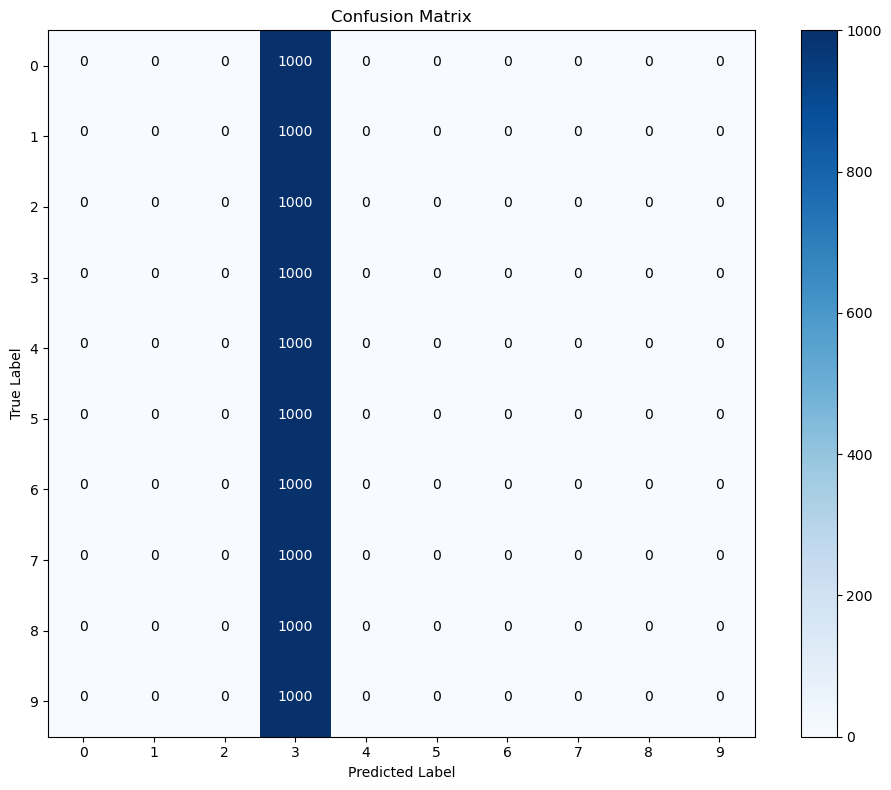

In [35]:
# Compute and display per-class metrics
metrics = compute_per_class_metrics(conf_matrix)
print("\nPer-class metrics:")
for i in range(10):  # For MNIST's 10 classes
    print(f"\nClass {i}:")
    print(f"Precision: {metrics['precision'][i]:.4f}")
    print(f"Recall: {metrics['recall'][i]:.4f}")
    print(f"F1 Score: {metrics['f1_score'][i]:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add numbers to confusion matrix
thresh = conf_matrix.max() / 2
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                horizontalalignment="center",
                color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

## 3. Complex FFNN

In [12]:
# Enhanced activation functions
def relu(x):
    """ReLU activation function"""
    return np.maximum(0, x)

def relu_derivative(x):
    """Derivative of ReLU"""
    return np.where(x > 0, 1, 0)

def softmax(x):
    """Stable Softmax"""
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Enhanced initialization
def initialize_network(input_size, hidden_layers, output_size):
    """Initialize network with He initialization"""
    layers = [input_size] + hidden_layers + [output_size]
    weights = []
    biases = []
    
    for i in range(len(layers)-1):
        # He initialization for weights
        scale = np.sqrt(2.0 / layers[i])
        weights.append(np.random.randn(layers[i], layers[i+1]) * scale)
        biases.append(np.zeros((1, layers[i+1])))
    
    return weights, biases

# Enhanced forward propagation with layer normalization
def forward_propagation(X, weights, biases, training=True):
    """Forward propagation with layer normalization and dropout"""
    activations = [X]
    z_values = []
    dropout_masks = []
    normalized_values = []
    
    dropout_rate = 0.3 if training else 0.0
    epsilon = 1e-8
    
    for i, (w, b) in enumerate(zip(weights, biases)):
        # Linear transformation
        z = np.dot(activations[-1], w) + b
        z_values.append(z)
        
        # Layer normalization (except for output layer)
        if i < len(weights) - 1:
            mean = np.mean(z, axis=1, keepdims=True)
            var = np.var(z, axis=1, keepdims=True)
            z_norm = (z - mean) / np.sqrt(var + epsilon)
            normalized_values.append((z_norm, mean, var))
            z = z_norm  # Use normalized values
        
        # Activation
        if i == len(weights) - 1:
            activation = softmax(z)
        else:
            activation = relu(z)
            
            # Apply dropout during training
            if training:
                mask = np.random.binomial(1, 1-dropout_rate, size=activation.shape) / (1-dropout_rate)
                activation *= mask
                dropout_masks.append(mask)
            
        activations.append(activation)
    
    cache = {
        'activations': activations,
        'z_values': z_values,
        'dropout_masks': dropout_masks,
        'normalized_values': normalized_values
    }
    
    return activations[-1], cache

def forward_propagation(X, weights, biases, training=True):
    """Forward propagation with layer normalization and dropout"""
    activations = [X]
    z_values = []
    dropout_masks = []
    normalized_values = []
    
    dropout_rate = 0.3 if training else 0.0
    epsilon = 1e-8
    
    for i, (w, b) in enumerate(zip(weights, biases)):
        # Linear transformation
        z = np.dot(activations[-1], w) + b
        z_values.append(z)
        
        # Layer normalization (except for output layer)
        if i < len(weights) - 1:
            mean = np.mean(z, axis=1, keepdims=True)
            var = np.var(z, axis=1, keepdims=True)
            z_norm = (z - mean) / np.sqrt(var + epsilon)
            normalized_values.append((z_norm, mean, var))
            z = z_norm  # Use normalized values
        
        # Activation
        if i == len(weights) - 1:
            activation = softmax(z)
        else:
            activation = relu(z)
            
            # Apply dropout during training
            if training:
                mask = np.random.binomial(1, 1-dropout_rate, size=activation.shape) / (1-dropout_rate)
                activation *= mask
                dropout_masks.append(mask)
            
        activations.append(activation)
    
    cache = {
        'activations': activations,
        'z_values': z_values,
        'dropout_masks': dropout_masks,
        'normalized_values': normalized_values
    }
    
    return activations[-1], cache

# Update backward propagation to use ReLU derivative
def backward_propagation(y_true, cache, weights):
    """Backward propagation with normalization and dropout"""
    gradients_w = []
    gradients_b = []
    m = y_true.shape[0]
    
    activations = cache['activations']
    z_values = cache['z_values']
    dropout_masks = cache['dropout_masks']
    normalized_values = cache['normalized_values']
    
    # Initialize gradient
    dz = activations[-1] - y_true
    
    for i in reversed(range(len(weights))):
        # Compute gradients for weights and biases
        dw = np.dot(activations[i].T, dz) / m
        db = np.sum(dz, axis=0, keepdims=True) / m
        
        gradients_w.insert(0, dw)
        gradients_b.insert(0, db)
        
        # Compute gradient for next layer
        if i > 0:
            dz = np.dot(dz, weights[i].T)
            
            # Apply dropout mask if not in last layer
            if i < len(weights) - 1:
                dz *= dropout_masks[i-1]
            
            # Gradient through ReLU
            dz *= relu_derivative(z_values[i-1])
            
            # Gradient through layer normalization
            if i < len(weights) - 1:
                z_norm, mean, var = normalized_values[i-1]
                epsilon = 1e-8
                dz = dz / np.sqrt(var + epsilon)
    
    return gradients_w, gradients_b

# Enhanced training function with learning rate decay
def train_network(X_train, y_train, X_val, y_val, input_size, hidden_layers, output_size, epochs, learning_rate):
    """Training with learning rate decay and early stopping"""
    weights, biases = initialize_network(input_size, hidden_layers, output_size)
    train_losses, val_losses = [], []
    
    # Early stopping parameters
    patience = 10
    min_val_loss = float('inf')
    patience_counter = 0
    best_weights = None
    best_biases = None
    
    # Learning rate decay parameters
    decay_rate = 0.95
    decay_steps = 10
    
    for epoch in range(epochs):
        # Decay learning rate
        if epoch % decay_steps == 0 and epoch > 0:
            learning_rate *= decay_rate
        
        # Mini-batch training
        batch_size = 128
        indices = np.random.permutation(len(X_train))
        total_loss = 0
        
        for start_idx in range(0, len(X_train), batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            # Forward pass
            predictions, cache = forward_propagation(X_batch, weights, biases, training=True)
            
            # Compute loss
            epsilon = 1e-15
            loss = -np.mean(np.sum(y_batch * np.log(predictions + epsilon), axis=1))
            total_loss += loss
            
            # Backward pass
            gradients_w, gradients_b = backward_propagation(y_batch, cache, weights)
            
            # Update weights and biases
            for i in range(len(weights)):
                weights[i] -= learning_rate * gradients_w[i]
                biases[i] -= learning_rate * gradients_b[i]
        
        # Compute average training loss
        avg_train_loss = total_loss / (len(X_train) / batch_size)
        train_losses.append(avg_train_loss)
        
        # Validation
        val_predictions, _ = forward_propagation(X_val, weights, biases, training=False)
        val_loss = -np.mean(np.sum(y_val * np.log(val_predictions + epsilon), axis=1))
        val_losses.append(val_loss)
        
        # Early stopping check
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            patience_counter = 0
            best_weights = [w.copy() for w in weights]
            best_biases = [b.copy() for b in biases]
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break
        
        # Print progress
        if epoch % 5 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}/{epochs}")
            print(f"Training Loss: {avg_train_loss:.4f}")
            print(f"Validation Loss: {val_loss:.4f}")
            print(f"Learning Rate: {learning_rate:.6f}")
            print("------------------------")
    
    return best_weights, best_biases, train_losses, val_losses

In [18]:
# Network parameters with deeper architecture
input_size = 784  # 28x28 pixels
hidden_layers = [
    512,  # First hidden layer
    1024,  # Second hidden layer
    512,  # Third hidden layer
    256,   # Fourth hidden layer
    128   # Fifth hidden layer
]
output_size = 10  # 10 digits
learning_rate = 0.01  # Reduced learning rate for stability
epochs = 50  # More epochs for better convergence

print("\nTraining Complex Network...")
weights, biases, train_losses, val_losses = train_network(
    X_train, y_train, X_val, y_val,
    input_size, hidden_layers, output_size,
    epochs, learning_rate
)


Training Complex Network...
Epoch 1/50
Training Loss: 1.6151
Validation Loss: 0.9050
Learning Rate: 0.010000
------------------------
Epoch 6/50
Training Loss: 0.7024
Validation Loss: 0.6016
Learning Rate: 0.010000
------------------------
Epoch 11/50
Training Loss: 0.5797
Validation Loss: 0.5100
Learning Rate: 0.009500
------------------------
Epoch 16/50
Training Loss: 0.5192
Validation Loss: 0.4641
Learning Rate: 0.009500
------------------------
Epoch 21/50
Training Loss: 0.4746
Validation Loss: 0.4351
Learning Rate: 0.009025
------------------------
Epoch 26/50
Training Loss: 0.4454
Validation Loss: 0.4173
Learning Rate: 0.009025
------------------------
Epoch 31/50
Training Loss: 0.4242
Validation Loss: 0.3990
Learning Rate: 0.008574
------------------------
Epoch 36/50
Training Loss: 0.4116
Validation Loss: 0.3874
Learning Rate: 0.008574
------------------------
Epoch 41/50
Training Loss: 0.4077
Validation Loss: 0.3863
Learning Rate: 0.008145
------------------------
Epoch 46/5

In [19]:
def compute_accuracy(y_true, y_pred):
    """Compute accuracy for classification predictions"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # If y_true is one-hot encoded, convert to class indices
    if y_true.ndim > 1 and y_true.shape[1] > 1:
        y_true_labels = np.argmax(y_true, axis=1)
    else:
        y_true_labels = y_true
    
    # If y_pred is probabilities or one-hot encoded, convert to class indices
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:
        y_pred_labels = np.argmax(y_pred, axis=1)
    else:
        y_pred_labels = y_pred
    
    correct_predictions = np.sum(y_true_labels == y_pred_labels)
    total_predictions = len(y_true_labels)
    
    return correct_predictions / total_predictions

def compute_confusion_matrix(y_true, y_pred):
    """Compute confusion matrix for classification predictions"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # If y_true is one-hot encoded, convert to class indices
    if y_true.ndim > 1 and y_true.shape[1] > 1:
        y_true_labels = np.argmax(y_true, axis=1)
    else:
        y_true_labels = y_true
    
    # If y_pred is probabilities or one-hot encoded, convert to class indices
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:
        y_pred_labels = np.argmax(y_pred, axis=1)
    else:
        y_pred_labels = y_pred
    
    # Get unique classes
    classes = np.unique(np.concatenate((y_true_labels, y_pred_labels)))
    num_classes = len(classes)
    
    # Create confusion matrix
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    for true, pred in zip(y_true_labels, y_pred_labels):
        conf_matrix[true, pred] += 1
    
    return conf_matrix

def evaluate_model(X_test, y_test, weights, biases):
    """Evaluate model performance on test data"""
    # Perform forward propagation
    predictions, _ = forward_propagation(X_test, weights, biases, training=False)
    
    # Compute accuracy
    accuracy = compute_accuracy(y_test, predictions)
    
    # Compute confusion matrix
    conf_matrix = compute_confusion_matrix(y_test, predictions)
    
    return accuracy, conf_matrix

In [20]:
accuracy, conf_matrix = evaluate_model(X_test, y_test, weights, biases)
print(f"\nTest Accuracy: {accuracy:.4f}")


Test Accuracy: 0.8567


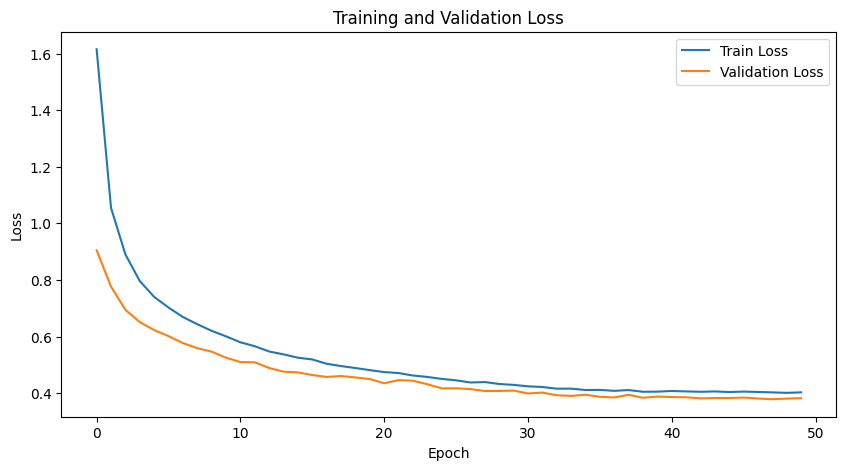

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [22]:
# Compute and display per-class metrics
metrics = compute_per_class_metrics(conf_matrix)
print("\nPer-class metrics:")
for i in range(10):  # For MNIST's 10 classes
    print(f"\nClass {i}:")
    print(f"Precision: {metrics['precision'][i]:.4f}")
    print(f"Recall: {metrics['recall'][i]:.4f}")
    print(f"F1 Score: {metrics['f1_score'][i]:.4f}")


Per-class metrics:

Class 0:
Precision: 0.8236
Recall: 0.7750
F1 Score: 0.7986

Class 1:
Precision: 0.9865
Recall: 0.9530
F1 Score: 0.9695

Class 2:
Precision: 0.7955
Recall: 0.7430
F1 Score: 0.7684

Class 3:
Precision: 0.8713
Recall: 0.8530
F1 Score: 0.8621

Class 4:
Precision: 0.7592
Recall: 0.8070
F1 Score: 0.7824

Class 5:
Precision: 0.9631
Recall: 0.9390
F1 Score: 0.9509

Class 6:
Precision: 0.5882
Recall: 0.6600
F1 Score: 0.6221

Class 7:
Precision: 0.9220
Recall: 0.9340
F1 Score: 0.9280

Class 8:
Precision: 0.9615
Recall: 0.9480
F1 Score: 0.9547

Class 9:
Precision: 0.9354
Recall: 0.9550
F1 Score: 0.9451


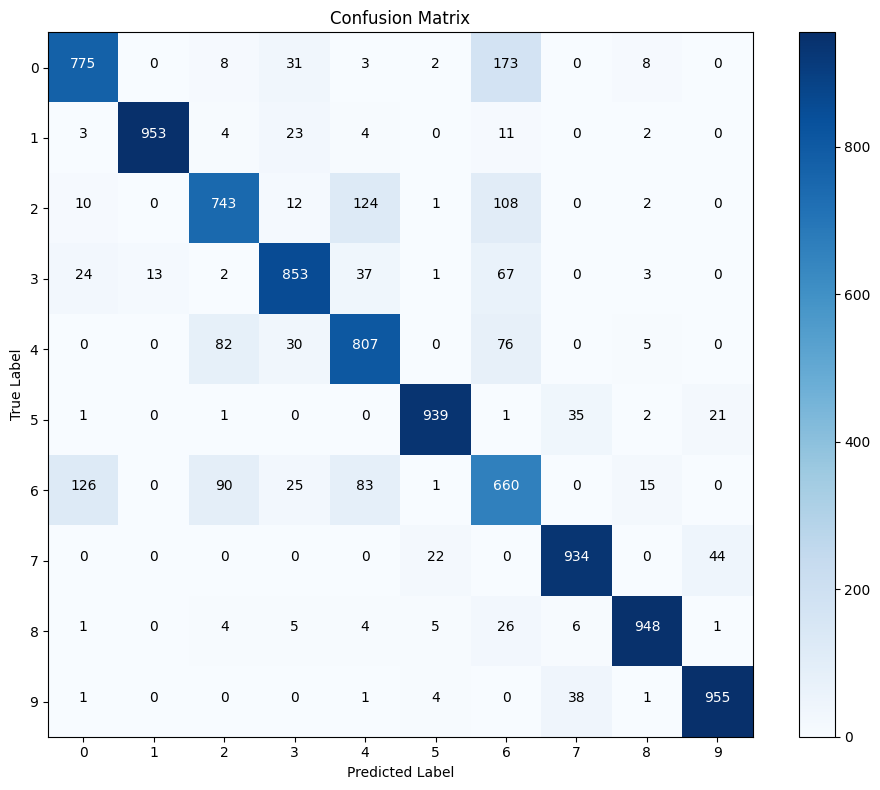

In [23]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add numbers to confusion matrix
thresh = conf_matrix.max() / 2
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                horizontalalignment="center",
                color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()